In [2]:
#First, import all the necessary libraries into our notebook. LibROSA and SciPy are the Python libraries used for 
# processing audio signals.
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

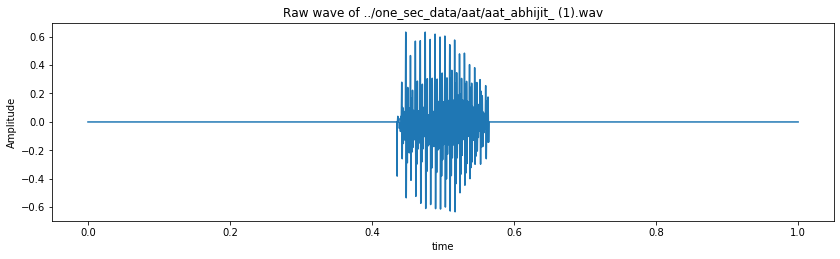

In [3]:
# Now, we’ll visualize the audio signal in the time series domain:
train_audio_path = './one_sec_data'   #'./train/audio/'
#'../input/tensorflow-speech-recognition-challenge/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'/aat/aat_abhijit_ (1).wav', sr = 16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '../one_sec_data/aat/aat_abhijit_ (1).wav')
#../input/train/audio/yes/0a7c2a8d_nohash_0.wav
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)


In [4]:
#Let us now look at the sampling rate of the audio signals:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [5]:
#From the above, we can understand that the sampling rate of the signal is 16,000 Hz. Let us re-sample it to 8000 Hz 
# since most of the speech-related frequencies are present at 8000 Hz:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

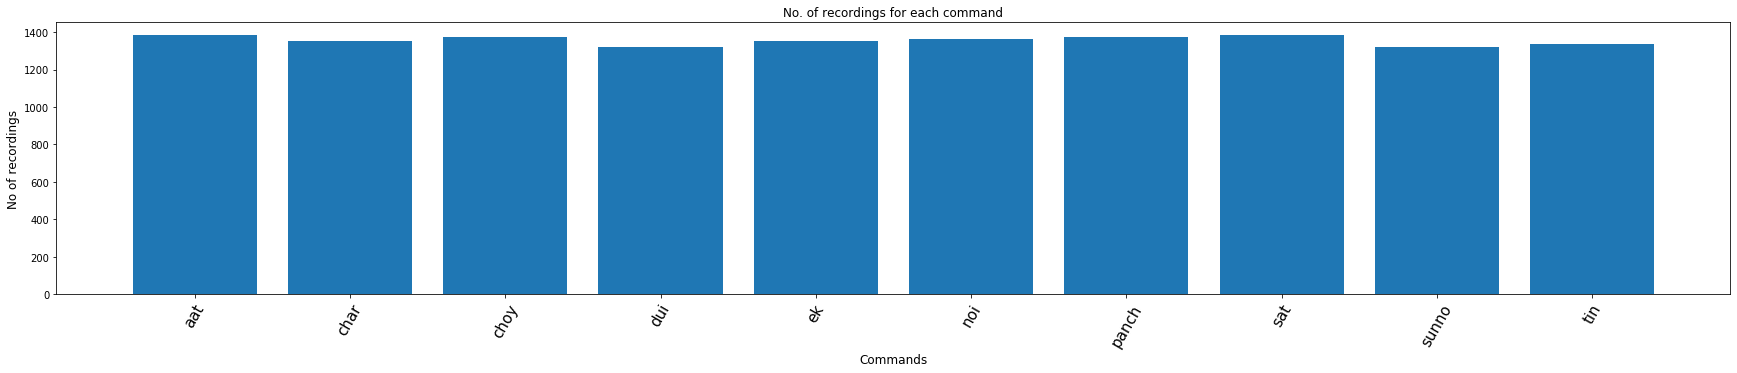

In [6]:
#Now, let’s understand the number of recordings for each voice command:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["ek", "dui", "tin", "char", "panch", "choy", "sat", "aat", "noi", "sunno"]

(array([    0.,     0.,     0.,     0.,     0., 13554.,     0.,     0.,
            0.,     0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

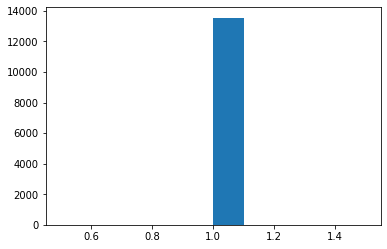

In [7]:
#A look at the distribution of the duration of recordings:
duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [8]:
# Preprocessing the audio waves.......Here are the two steps we’ll follow:
# 1. Resampling
# 2. Removing shorter commands of less than 1 second
train_audio_path = './one_sec_data/'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

ek
dui
tin
char
panch
choy
sat
aat
noi
sunno


In [9]:
#Convert the output labels to integer encoded:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [10]:
#Now, convert the integer encoded labels to a one-hot vector since it is a multi-classification problem:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [11]:
#Reshape the 2D array to 3D since the input to the conv1d must be a 3D array:
all_wave = np.array(all_wave).reshape(-1,8000,1)

In [12]:
all_wave.shape
#len(all_wave[0]

(13554, 8000, 1)

In [13]:
#Split into train and validation set
#Next, we will train the model on 80% of the data and validate on the remaining 20%:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [14]:
#Model Architecture for this problem
#We will build the speech-to-text model using conv1d. Conv1d is a convolutional neural network which performs the convolution along only one dimension. 
# https://www.analyticsvidhya.com/blog/2019/07/learn-build-first-speech-to-text-model-python/
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [15]:
#Define the loss function to be categorical cross-entropy since it is a multi-classification problem:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
#Early stopping and model checkpoints are the callbacks to stop training the neural network at the right time and 
# to save the best model after every epoch:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [17]:
# Let us train the model on a batch size of 32 and evaluate the performance on the holdout set:
import statistics
import time
start_train= time.time()
history=model.fit(x_tr, y_tr ,epochs=50, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))
end_train = time.time()
print(f"Train_time: {end_train-start_train}")

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
339/339 [==============================] - ETA: 0s - loss: 1.6581 - accuracy: 0.3710WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000003758E645E8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`

Epoch 22/50
339/339 [==============================] - 57s 169ms/step - loss: 0.1277 - accuracy: 0.9592 - val_loss: 0.1575 - val_accuracy: 0.9539
Epoch 23/50
339/339 [==============================] - 58s 170ms/step - loss: 0.1431 - accuracy: 0.9541 - val_loss: 0.1524 - val_accuracy: 0.9550
Epoch 24/50
339/339 [==============================] - 60s 178ms/step - loss: 0.1211 - accuracy: 0.9589 - val_loss: 0.1594 - val_accuracy: 0.9520
Epoch 25/50
339/339 [==============================] - 58s 172ms/step - loss: 0.1192 - accuracy: 0.9600 - val_loss: 0.1801 - val_accuracy: 0.9509
Epoch 26/50
339/339 [==============================] - 58s 171ms/step - loss: 0.1227 - accuracy: 0.9585 - val_loss: 0.1473 - val_accuracy: 0.9517
Epoch 27/50
339/339 [==============================] - 58s 171ms/step - loss: 0.1002 - accuracy: 0.9676 - val_loss: 0.2123 - val_accuracy: 0.9517
Epoch 28/50
339/339 [==============================] - 58s 172ms/step - loss: 0.1230 - accuracy: 0.9589 - val_loss: 0.1876 -

In [21]:
import pickle
import sys

p = pickle.dumps(history)
print(sys.getsizeof(p)/1024) #KB

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity t

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(classes)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

In [23]:
model.save('best_model_bengali_full.hdf5')

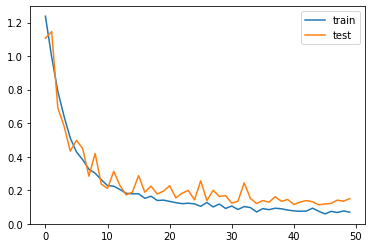

In [24]:
#I’m going to lean on visualization again to understand the performance of the model over a period of time:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

In [25]:
#Loading the best model
from keras.models import load_model
model=load_model('best_model_bengali_full.hdf5')

In [26]:
#define the function that predicts text for the given audio:
def predict(audio):
    prob=model.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [28]:
#Prediction time! Make predictions on the validation data:
import random
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: tin
Text: tin


In [35]:
#The best part is yet to come! Here is a script that prompts a user to record voice commands. 
#Record your own voice commands and test it on the model:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [34]:
#Let us now read the saved voice command and convert it to text:
os.listdir('./voice-commands')
filepath='./voice-commands'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'yes.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000) 



In [36]:
predict(samples)

'choy'

In [37]:
samples, sample_rate = librosa.load(filename, sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000) 

In [38]:
predict(samples)

'sunno'

In [50]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_val, y_val, batch_size=8)  #saved_model
print("test loss, test acc:", results)

Evaluate on test data
339/339 [==============================] - 3s 10ms/step - loss: 0.1500 - accuracy: 0.9605
test loss, test acc: [0.14998042583465576, 0.9605311751365662]


In [40]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

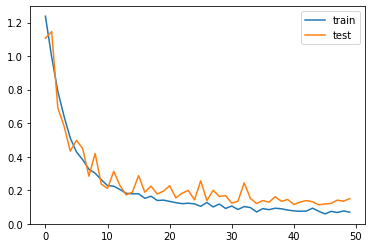

In [41]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

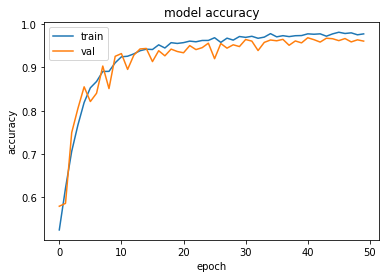

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
import tensorflow as tf
y_predict=model.predict(x_val)
conf_mat=tf.math.confusion_matrix(np.argmax(y_val,axis=1) , np.argmax(y_predict,axis=1))

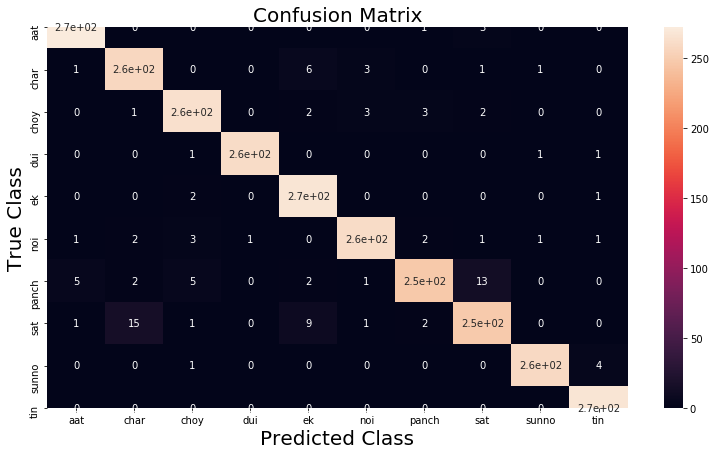

In [44]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(np.array(conf_mat), index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (13,7))
ax = sn.heatmap(df_cm, annot=True)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel("True Class"     , fontsize=20)
plt.xlabel("Predicted Class", fontsize=20)
plt.show()

In [32]:
predicted_classes=model.predict(x_val)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes

array([4, 2, 1, ..., 0, 4, 0], dtype=int64)

In [34]:
y_val = np.argmax(np.round(y_val),axis=1)

In [36]:
predicted_classes.shape, y_val.shape

((2711,), (2711,))

In [40]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(10)]
print(classification_report(y_val, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.89      0.99      0.94       276
     Class 1       0.97      0.94      0.95       270
     Class 2       0.96      0.95      0.95       275
     Class 3       0.99      0.98      0.99       264
     Class 4       0.97      0.97      0.97       270
     Class 5       0.97      0.96      0.97       273
     Class 6       0.95      0.91      0.93       275
     Class 7       0.95      0.93      0.94       277
     Class 8       0.97      0.98      0.98       264
     Class 9       0.99      0.99      0.99       267

    accuracy                           0.96      2711
   macro avg       0.96      0.96      0.96      2711
weighted avg       0.96      0.96      0.96      2711



In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix(predicted_classes, y_val)

array([[272,   4,   6,   1,   2,   4,   9,   5,   2,   0],
       [  1, 253,   1,   0,   1,   1,   1,   3,   0,   0],
       [  0,   2, 260,   0,   0,   3,   2,   3,   0,   0],
       [  0,   1,   0, 259,   0,   1,   0,   0,   0,   0],
       [  1,   4,   2,   0, 263,   0,   1,   1,   0,   0],
       [  0,   1,   4,   1,   1, 263,   2,   0,   0,   0],
       [  0,   2,   2,   0,   2,   0, 251,   7,   1,   0],
       [  2,   3,   0,   0,   0,   0,   9, 257,   0,   0],
       [  0,   0,   0,   2,   0,   1,   0,   1, 260,   3],
       [  0,   0,   0,   1,   1,   0,   0,   0,   1, 264]], dtype=int64)